## Packages

In [2]:
from utils import *
import glob,os,os.path, numpy as np
import matplotlib.pyplot as plt

4.6.0


## Main Section

In [ ]:
#----------------------ROOT folder setup---------------------#
Root1 = "./Brownian_motion"
Root2 = "./Export"

In [ ]:
#----------------------Envs folder setup---------------------#
# Create folder "TrackFile"
root_dir = './Export/TrackFile'
groups = ['1', '2', '3', '4', '5','Free','Laser'] # Named after group
makefolders(root_dir,subfolders=groups)
# Create folder "RawData"
if os.path.exists("./Export/RawData") == False:
    os.mkdir("./Export/RawData")

In [ ]:
#----------------------Convert to animation---------------------#
# Convert sequenes of images(.tif) into animantion(.mp4) -/RawData
for index in groups:
    SrcFolder=f"{Root1}/{index}"
    OutFolder=f"{Root2}/RawData"
    IMG2MP4(SrcFolder, OutFolder, OutName=f'{index}', FPS=5)

In [ ]:
#-------------------------Track through ROI------------------------# 
for index in groups:
    SrcFolder=f"./Brownian_motion/{index}"
    OutFolder=f"{Root2}/TrackFile"
    Track(SrcFolder, OutFolder, OutName=f"{index}", SavePlot=True)

In [ ]:
#----------------------Convert to animationn---------------------#
# Convert sequenes of images(.jpg) into animantion(.mp4/.gif) -/TrackFile
print(f"\nConverting into animation...")
for index in groups:
    SrcFolder=f"{Root2}/TrackFile/{index}"
    OutFolder=f"{Root2}/TrackFile"
    IMG2MP4(SrcFolder, OutFolder, OutName=f'Track_{index}', FPS=5)
    PNG2GIF(SrcFolder, OutFolder, OutName=f"Track_{index}",ImgFormat="png", duration=120)

print("////"*18)

## OpenCV image processing methods

Picture size:(65, 65, 3), picture type:uint8


(-0.5, 64.5, 64.5, -0.5)

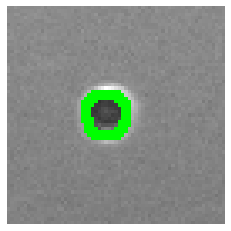

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

im = cv2.imread("./Brownian _motion/1_laser1/laser1_0001.tif")
print(f"Picture size:{im.shape}, picture type:{im.dtype}")

plt.imshow(im, cmap="gray");plt.axis('off')
blur = cv2.GaussianBlur(im, (11, 11), 0)
plt.imshow(blur, cmap='gray');plt.axis('off')

canny = cv2.Canny(blur, 30, 150, 3)
plt.imshow(canny, cmap='gray');plt.axis('off')

dilated = cv2.dilate(canny, (1, 1), iterations=0)
plt.imshow(dilated, cmap='gray');plt.axis('off')

(cnt, hierarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
cv2.drawContours(rgb, cnt, -1, (0, 255, 0), 2)

plt.imshow(rgb);plt.axis('off')

## Method1-Hough Gradient Method

In [6]:
## Hough Gradient Method
#https://docs.opencv.org/4.x/da/d53/tutorial_py_houghcircles.html
import cv2
import numpy as np
image = cv2.imread('./Brownian _motion/laser/laser1_0008.tif',0)
#image = cv2.imread('test.jpeg')
output = image.copy()
#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.medianBlur(image,5)  
circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT,1,20,\
                            param1=50,param2=10,minRadius=5,maxRadius=30)
# If some circle is found
if circles is not None:
   # Get the (x, y, r) as integers
   circles = np.uint16(np.around(circles))
   print(circles)
   # loop over the circles
   for i in circles[0,:]:
      # draw the outer circle
      cv2.circle(image,(i[0],i[1]),i[2],(0,255,0),1)
      # draw the center of the circle
      cv2.circle(image,(i[0],i[1]),2,(168, 50, 147),1)
      interval = 6
      x1=i[0]-(i[2] +interval)
      y1=i[1]-(i[2] +interval)      
      x2=i[0]+(i[2] +interval)
      y2=i[1]+(i[2] +interval)
      print(x1, y1, x2, y2)


cv2.imwrite("output.jpeg",image)

[[[30 32  6]]]
18 20 42 44


True

## Method2-Template Matchingin OpenCV

In [ ]:
## Template Matchingin OpenCV
#https://docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv.imread('messi5.jpg',0)
img2 = img.copy()
template = cv.imread('template.jpg',0)
w, h = template.shape[::-1]
# All the 6 methods for comparison in a list
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
for meth in methods:
    img = img2.copy()
    method = eval(meth)
    # Apply template Matching
    res = cv.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img,top_left, bottom_right, 255, 2)
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

## Track

In [46]:
def Track(SrcFolder, OutFolder,OutName="test" ,SavePlot=True):
    Corr =[0,0,0,0,0,0,0]
    list_x ,list_y = [],[]

    #---------ROI section--------------------------------------------------------------------------------
    FileNumber = len(os.listdir(SrcFolder))
    ROI_INDEX = np.random.randint(0,FileNumber)

    template = ReadGrayImg(f"{SrcFolder}/{sorted(os.listdir(SrcFolder))[ROI_INDEX]}", False)        
    output = cv2.cvtColor(template, cv2.COLOR_GRAY2BGR)
    blur = cv2.medianBlur(template,5)  
    circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT,1,20,param1=50,param2=10,minRadius=3,maxRadius=20)
    print("////"*18)
    print(f"Currenet analysis image: {OutName}")
    if circles is not None:
        # Get the (x, y, r) as integers
        circles = np.uint16(np.around(circles))
        #print(circles)
        # loop over the circles
        for i in circles[0,:]:
            cv2.circle(output,(i[0],i[1]),i[2],(100, 103, 227),-1) # draw outer
            #cv2.circle(image, center_coordinates, radius, color, thickness)
            #Thickness of -1 px will fill the circle shape by the specified color.
            cv2.circle(output,(i[0],i[1]),1,(255,0,0),1) # draw center
            interval = 3
            x1= i[0] - (i[2]+interval); Corr[0]=x1
            x2= i[0] + (i[2]+interval); Corr[2]=x2
            y1= i[1] - (i[2]+interval); Corr[1]=y1
            y2= i[1] + (i[2]+interval); Corr[3]=y2
            Corr[4]=i[0] # center X
            Corr[5]=i[1] # center Y
            Corr[5]=i[2] # circle radius

            print(f"CenterX,CenterY:({i[0]},{i[1]}); radius:{i[2]}; x1,y1:({x1},{y1}), (x2,y2):({x2},{y2})")

        
    #cv2.imwrite(f"./Export/TrackFile/ROI/{OutName}_ROI.jpeg",output)
    roi = template.copy()
    cv2.circle(roi,(Corr[4],Corr[5]),Corr[6],(255, 0, 0),-1)
    roi = np.asarray(roi)[Corr[1]:Corr[3], Corr[0]:Corr[2]] #26:44,18:34]# opposite input seleciton
    roi = cv2.GaussianBlur(roi,(5,5),0)  
    #roi = Toolkits.xdog_garygrossi(roi,sigma=0.5,k=200, gamma=0.98,epsilon=0.1,phi=10)

    #---------NormalXCorr--------------------------------------------------------------------------------
    for filename in sorted(os.listdir(SrcFolder)):
        #num1, num2 = str(index).zfill(4), str(index+1).zfill(4)
        image = ReadGrayImg(f"{SrcFolder}/{filename}", False)
        imarray1 = np.asarray(image)
        imarray1 = cv2.GaussianBlur(imarray1,(7,7),0)
        #kernel = np.ones((3,3), np.uint8)
        #imarray1 = cv2.erode(imarray1, kernel, iterations = 1)
        #imarray1 = cv2.dilate(imarray1, kernel, iterations = 1)
        #imarray1 = Toolkits.xdog_garygrossi(imarray1,sigma=0.5,k=200, gamma=0.98,epsilon=0.1,phi=10)
                   
        #Cross correlation
        corr = normxcorr2(roi, imarray1, mode="same")
        y, x = np.unravel_index(np.argmax(corr), corr.shape)  # find the match
        #print(f"x:{x},y:{y}")
        list_x.append(x),list_y.append(y)
        
        if SavePlot == True:
            fig, (ax_orig, ax_corr) = plt.subplots(1, 2)
            ax_orig.imshow(imarray1, cmap='gray')
            ax_orig.set_title(f'{filename}(Image)')
            ax_orig.plot(x, y, 'ro',linewidth=2, markersize=12)
            ax_orig.set_axis_off()

            ax_corr.imshow(roi, cmap='gray')
            ax_corr.set_title(f'No.{ROI_INDEX}(ROI/Template)')
            ax_corr.set_axis_off()
            fig.tight_layout()
            filename = filename.replace(".tif","")
            plt.savefig(f"{OutFolder}/{OutName}/{filename}.png", bbox_inches='tight')
            plt.cla()
            plt.close(fig)         
    print(f"image shape:{imarray1.shape}, ROI:{roi.shape}\n")
    return list_x, list_y

In [94]:
#for interval in range(0,100): # Delta 1-100

X =[-14,1,2,2,-7,1]
Y =[-9,-3,-6,-6,-9,-5]

def cal(X ,Y, filename,length=len(X)):
    sol=[];y=[]
    #interval = 1 # loop over every possibel interval
    for interval in range(1,length): 
        dx1=[];dy1=[];avg_x=0;avg_y=0   
        for i in range(0,length):
            if (i+interval) < length:
                dx1.append(int(X[i+interval] - X[i]) **2)
                dy1.append(int(Y[i+interval] - Y[i]) **2)
        #print(dx1,dy1)
        avg_x = sum(dx1)/len(dx1)
        avg_y = sum(dy1)/len(dy1)
        sol.append(avg_x + avg_y)
        #print(avg_x,avg_y)
    
    y = sol
    x = np.linspace(1,length-1,length-1)
    fig = plt.figure(figsize=(10,5))
    plt.plot(x,y) 
    plt.title(f"{filename}")
    plt.xlabel("Time interval"); plt.ylabel("MSD")
    plt.axis([1,length,min(y)*0.8,max(y)*1.2])
    plt.show()
    fig.savefig(f"{Root2}/TrackFile/{filename}.png")       
    return sol


////////////////////////////////////////////////////////////////////////
Currenet analysis image: 1
CenterX,CenterY:(38,34); radius:11; x1,y1:(24,20), (x2,y2):(52,48)
image shape:(64, 64), ROI:(28, 28)



/var/folders/1z/by3dhv6x3fsfqlxysgxnx1y80000gn/T/ipykernel_62447/1499092305.py:28: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.axis([1,length,min(y)*0.8,max(y)*1.2])


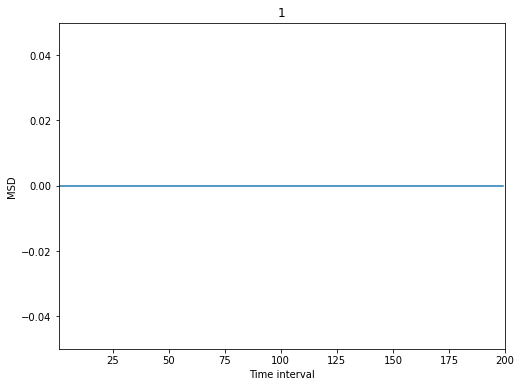

////////////////////////////////////////////////////////////////////////
Currenet analysis image: 2
CenterX,CenterY:(26,40); radius:6; x1,y1:(17,31), (x2,y2):(35,49)
image shape:(64, 64), ROI:(18, 18)



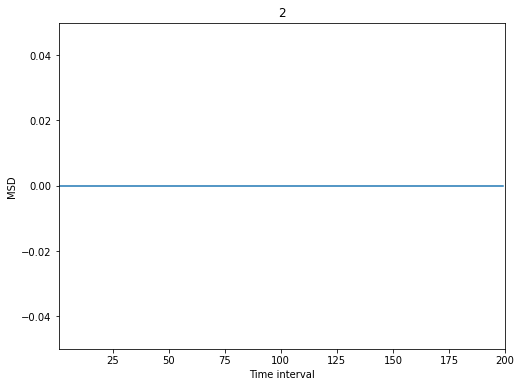

////////////////////////////////////////////////////////////////////////
Currenet analysis image: 3
CenterX,CenterY:(28,40); radius:11; x1,y1:(14,26), (x2,y2):(42,54)
image shape:(64, 64), ROI:(28, 28)



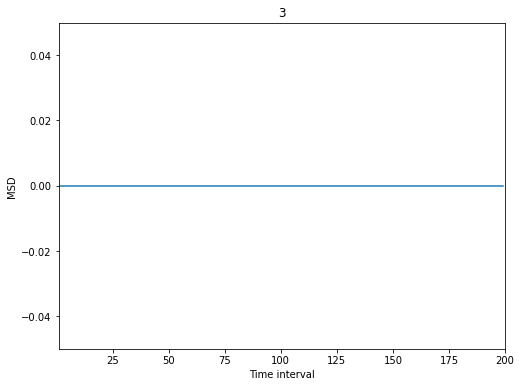

////////////////////////////////////////////////////////////////////////
Currenet analysis image: 4
CenterX,CenterY:(34,44); radius:10; x1,y1:(21,31), (x2,y2):(47,57)
image shape:(64, 64), ROI:(26, 26)



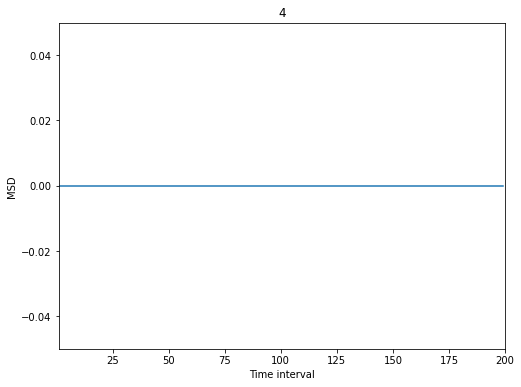

////////////////////////////////////////////////////////////////////////
Currenet analysis image: 5
CenterX,CenterY:(24,24); radius:11; x1,y1:(10,10), (x2,y2):(38,38)
image shape:(64, 64), ROI:(28, 28)



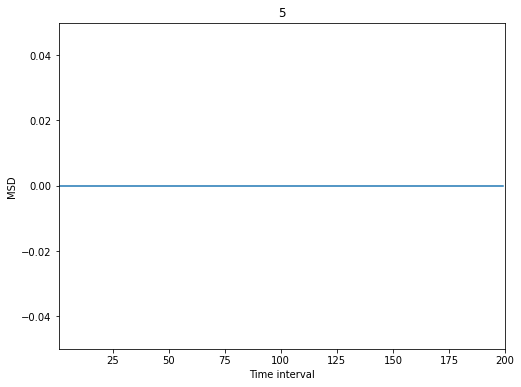

////////////////////////////////////////////////////////////////////////
Currenet analysis image: Free
CenterX,CenterY:(34,22); radius:7; x1,y1:(24,12), (x2,y2):(44,32)
image shape:(65, 65), ROI:(20, 20)



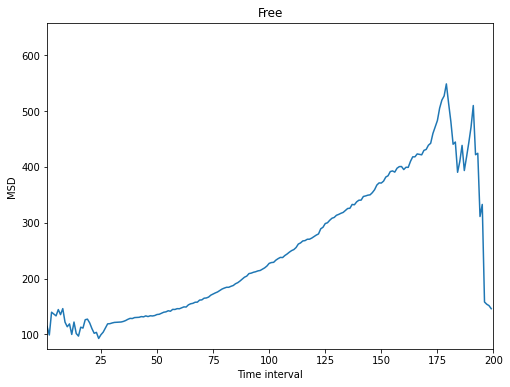

////////////////////////////////////////////////////////////////////////
Currenet analysis image: Laser
CenterX,CenterY:(30,32); radius:6; x1,y1:(21,23), (x2,y2):(39,41)
image shape:(65, 65), ROI:(18, 18)



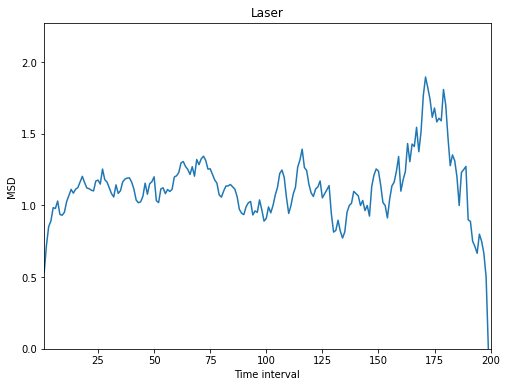

In [93]:
from utils import *
import numpy as np
import matplotlib.pyplot as plt

Root1 = "./Brownian_motion"
Root2 = "./Export"
groups = ['1', '2', '3', '4', '5','Free','Laser'] # Named after group

for index in groups:
    SrcFolder=f"./Brownian_motion/{index}"
    OutFolder=f"{Root2}/TrackFile"
    X,Y = Track(SrcFolder, OutFolder, OutName=f"{index}", SavePlot=True)
    cal(X ,Y, index,length=len(X))

In [ ]:
# Rename filename
folder="/Users/samchen/Documents/Code/Projects/Single_Particle_Tracking/Brownian_motion/5"
for file in sorted(os.listdir(folder)):
    NewName = file.replace("raw data_","")
    os.rename(f"{folder}/{file}",f"{folder}/{NewName}")
## Check revision result
#for file in sorted(os.listdir(folder)):
#    print(file)